In [ ]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/gtzan300.zip -O
! unzip -q -o gtzan300.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  385M  100  385M    0     0  62.7M      0  0:00:06  0:00:06 --:--:-- 70.8M


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

TypeError: ignored

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:10<00:00, 126MB/s]
100% 1.21G/1.21G [00:10<00:00, 129MB/s]


In [ ]:
!unzip -q gtzan-dataset-music-genre-classification

In [ ]:
import pandas as pd

df = pd.read_csv('./gtzan300.csv')
id_label = df.set_index('id')['label'].to_dict()

df.head(3)

,id,path,label
0,0,./train/hiphop/hiphop.00096.wav,hiphop
1,1,./train/hiphop/hiphop.00024.wav,hiphop
2,2,./train/hiphop/hiphop.00015.wav,hiphop


In [ ]:
!pip -q install librosa

In [ ]:
# audio libraries
import librosa
import librosa.display as lplt
import IPython
import librosa.display

import matplotlib.pyplot as plt , numpy as np , os , json
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import warnings
warnings.filterwarnings("ignore")

filename = "jazz.00054.wav"
try:
  song , sr = librosa.load(f'Data/genres_original/jazz/{filename}')
  librosa.display.waveplot(song)
except:
  print("Not possible to open ", filename)

Not possible to open  jazz.00054.wav


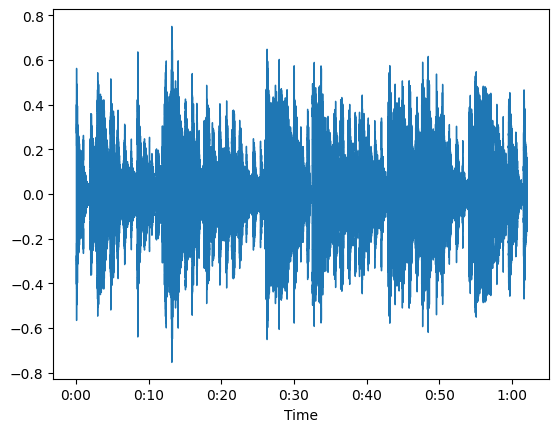

In [ ]:
import warnings
warnings.filterwarnings("ignore")

song, sr = librosa.load("test/jazz/jazz.00006.wav", sr = 45600)
librosa.display.waveshow(song)

In [ ]:
IPython.display.Audio(song, rate = sr)

<class 'numpy.ndarray'>


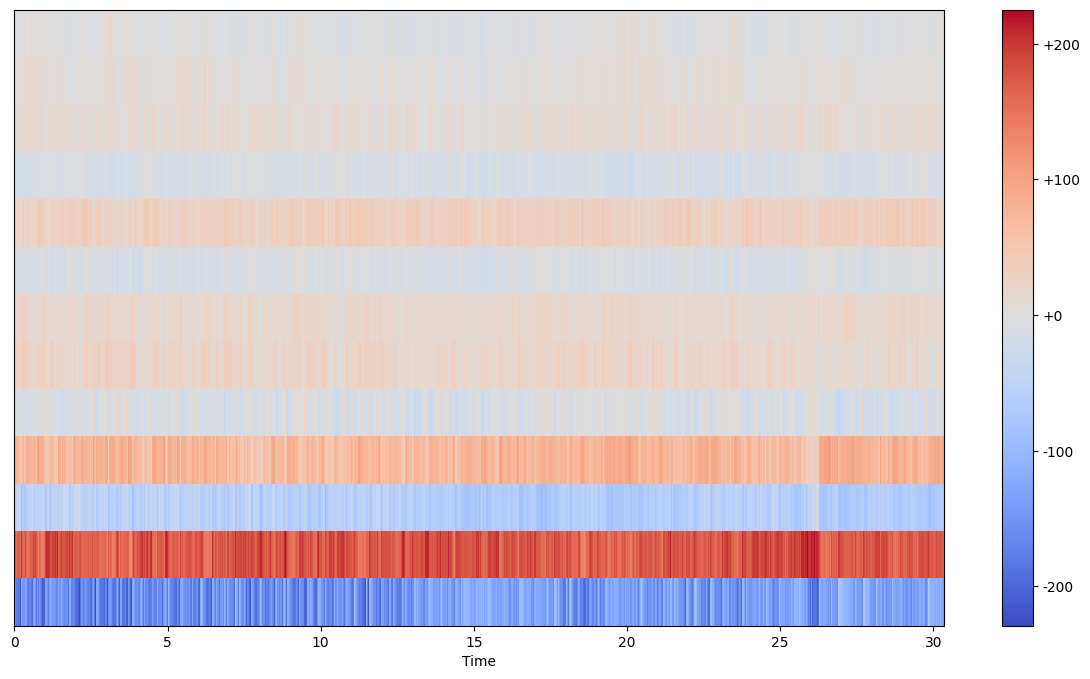

In [ ]:
mfcc_song = librosa.feature.mfcc(y=song, n_mfcc=13, sr=sr)
print(type(mfcc_song) )
plt.figure(figsize=(15, 8))
librosa.display.specshow(mfcc_song, x_axis="time", sr=sr)
plt.colorbar(format="%+2.f")
# Ploting the spectogram of the mfcc
plt.show()

In [ ]:
def preprocess_data(source_path):
  mydict = {
      "labels" : [] ,
        "mfcc" : []
        }
  sr = 22050
  Samples = 29 * sr
  NUM_SLICES = 10
  SAMPLES_PER_SLICE = int(Samples / NUM_SLICES)

  music = ['reggae', 'jazz', 'country', 'hiphop', 'rock', 'metal', 'classical', 'disco', 'blues', 'pop']

  path = source_path
  i = 0

  for n in music :
    new_path = path + n
    song = os.listdir(new_path)
    for p in song:
      if p != ".ipynb_checkpoints" :
        final_path = new_path + "/" + p
        #here we first walk through all the files and generate a 13 band mfcc for each sample and append it in the dict
        try:
          melody , sr = librosa.load(final_path , duration=29)
          #creating 10 samples for each file
          for s in range(NUM_SLICES):
            start_sample = SAMPLES_PER_SLICE * s
            end_sample = start_sample + SAMPLES_PER_SLICE
            mfcc = librosa.feature.mfcc(y=melody[start_sample : end_sample], sr=sr, n_mfcc=13)
            mfcc = mfcc.T
            mydict["labels"].append(i)
            mydict["mfcc"].append(mfcc.tolist())
        except:
          print("Format problem of ", filename)
    i+= 1
  with open("data.json", 'w') as f:
      json.dump(mydict, f)
  f.close()


**Loading all the files**



In [ ]:
def load_data(json_path):

  with open(json_path, 'r') as f:
      data = json.load(f)
  f.close()

  X = np.array(data["mfcc"])
  y = np.array(data["labels"])
  print(X.shape)

  return X, y

In [ ]:
preprocess_data("Data/genres_original/")

Format problem of  jazz.00006.wav


In [ ]:
x, y = load_data("data.json")

(9990, 125, 13)


In [ ]:
x = x.reshape( x.shape[0] , x.shape[1] , x.shape[2] , 1)

In [ ]:
train_data_in ,test_data_in , train_data_targets  ,  test_data_targets = train_test_split(x , y , test_size = 0.2)
inputs_train, inputs_test, targets_train, targets_test = train_test_split(train_data_in , train_data_targets, test_size=0.2)

In [ ]:
def design_model(input_shape):

  # Let's design the model architecture.
  model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

  return model

In [ ]:
shape_ = (125 , 13 , 1)
model1 = design_model(shape_)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 6, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 4, 64)         18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 30, 2, 64)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 1, 128)       

In [ ]:
model1.compile(
       optimizer = 'adam' ,
       loss = 'sparse_categorical_crossentropy' ,
       metrics = 'accuracy'
)

In [ ]:
model_history = model1.fit(
                        inputs_train, targets_train,
                        validation_data=(inputs_test, targets_test),
                        epochs=100,
                        batch_size=128
                        )

Epoch 1/100
50/50 [==============================] - 18s 321ms/step - loss: 2.2817 - accuracy: 0.2303 - val_loss: 1.6800 - val_accuracy: 0.3709
Epoch 2/100
50/50 [==============================] - 16s 317ms/step - loss: 1.5913 - accuracy: 0.4025 - val_loss: 1.4631 - val_accuracy: 0.4922
Epoch 3/100
50/50 [==============================] - 16s 326ms/step - loss: 1.4476 - accuracy: 0.4588 - val_loss: 1.4196 - val_accuracy: 0.4947
Epoch 4/100
50/50 [==============================] - 16s 321ms/step - loss: 1.3445 - accuracy: 0.4937 - val_loss: 1.2868 - val_accuracy: 0.5453
Epoch 5/100
50/50 [==============================] - 16s 320ms/step - loss: 1.2978 - accuracy: 0.5201 - val_loss: 1.3181 - val_accuracy: 0.5422
Epoch 6/100
50/50 [==============================] - 15s 306ms/step - loss: 1.2046 - accuracy: 0.5550 - val_loss: 1.2143 - val_accuracy: 0.6085
Epoch 7/100
50/50 [==============================] - 16s 316ms/step - loss: 1.1390 - accuracy: 0.5816 - val_loss: 1.0876 - val_accuracy:

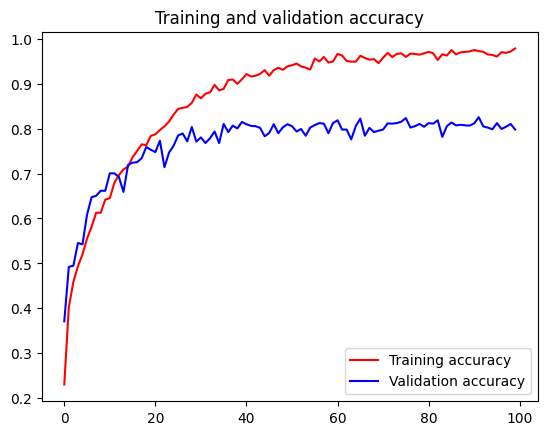

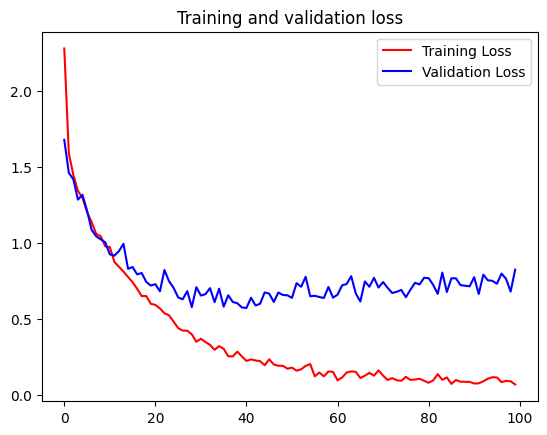

In [ ]:
model_history.history
def plot_performance(hist):

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_performance(model_history)

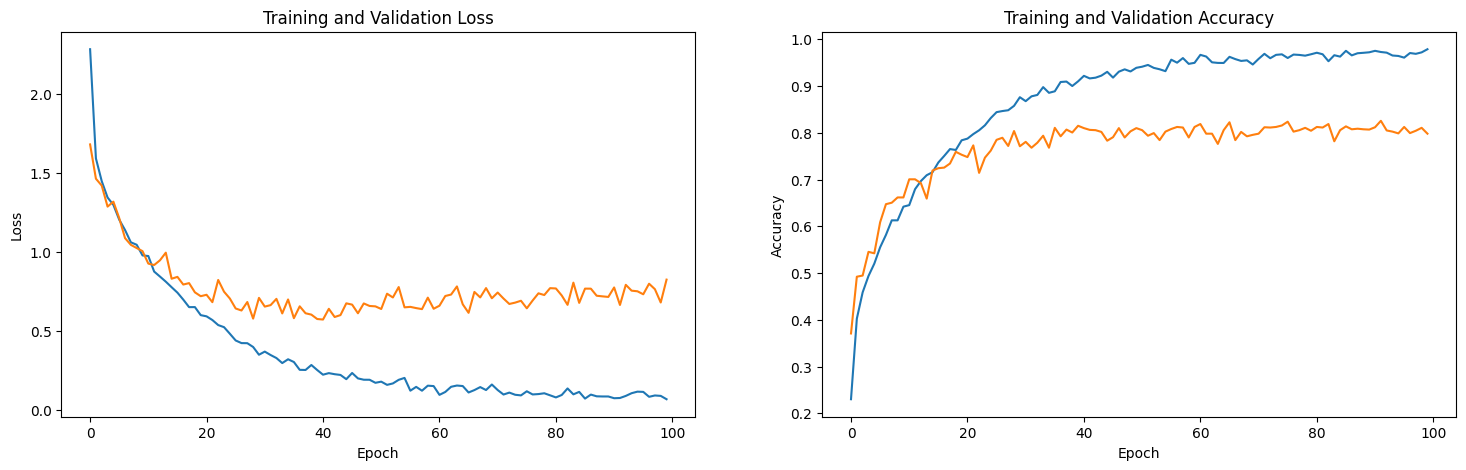

In [ ]:
fig = plt.figure(figsize=(18,5))
first_plot = fig.add_subplot(1,2,1)
#First plot
first_plot.plot(model_history.history["loss"],label="loss")
first_plot.plot(model_history.history["val_loss"],label="val_loss")
first_plot.set_xlabel("Epoch")
first_plot.set_ylabel("Loss")
first_plot.set_title("Training and Validation Loss")

#Second Plot
second_plot = fig.add_subplot(1,2,2)
second_plot.plot(model_history.history["accuracy"],label="accuracy")
second_plot.plot(model_history.history["val_accuracy"],label="val_accuracy")
second_plot.set_xlabel("Epoch")
second_plot.set_ylabel("Accuracy")
second_plot.set_title("Training and Validation Accuracy")

plt.show()

In [ ]:
predict = model1.predict(test_data_in)

63/63 [==============================] - 1s 18ms/step


In [ ]:
acc = 0
for i in range(len(predict)):
  if np.argmax(predict[i]) == test_data_targets[i]:
    acc += 1
print("Accuracy: {:.4f}".format((acc/len(predict))*100))

Accuracy: 79.5796


In [ ]:
test_loss, test_acc = model1.evaluate(test_data_in, test_data_targets, batch_size = 128)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

16/16 [==============================] - 1s 86ms/step - loss: 0.9194 - accuracy: 0.7958
The test loss is:  0.919380784034729
The best accuracy is:  79.57957983016968


In [ ]:
#!rm -r saved_model
!mkdir saved_model

In [ ]:
model1.save('saved_model/my_model')

In [ ]:
# contains an assets folder, saved_model.pb, and variables folder.
%ls saved_model/my_model

assets/  fingerprint.pb  keras_metadata.pb  saved_model.pb  variables/


In [ ]:
load_model = tf.keras.models.load_model('saved_model/my_model')
load_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 6, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 4, 64)         18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 30, 2, 64)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 1, 128)       

In [ ]:
test_loss, test_acc = load_model.evaluate(test_data_in, test_data_targets, batch_size = 128)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

16/16 [==============================] - 1s 55ms/step - loss: 0.9194 - accuracy: 0.7958
The test loss is:  0.919380784034729
The best accuracy is:  79.57957983016968


In [ ]:
test_loss, test_acc = load_model.evaluate(inputs_test, targets_test, batch_size = 32)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

50/50 [==============================] - 2s 47ms/step - loss: 0.8253 - accuracy: 0.7980
The test loss is:  0.8253341913223267
The best accuracy is:  79.79987263679504
